In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [6]:
data = pd.read_csv('Google_Stock_Price_Train.csv',thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


Text(0, 0.5, 'Stock Volume')

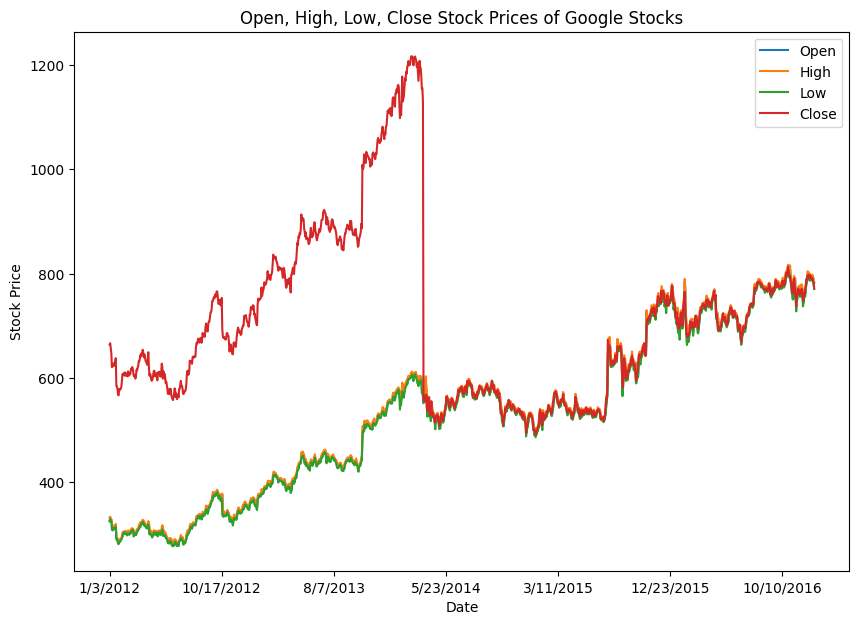

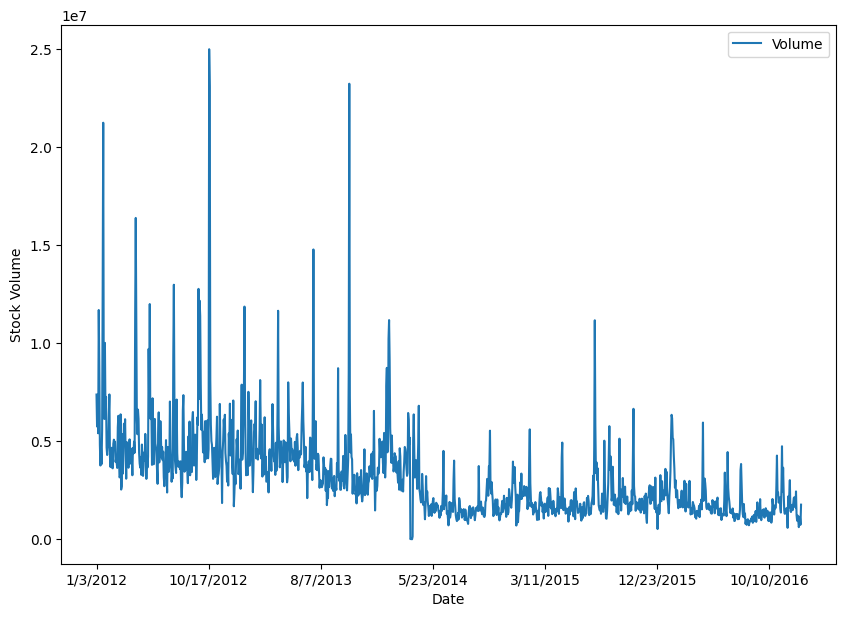

In [10]:
ax1 = data.plot(x="Date", y=["Open", "High", "Low", "Close"], figsize=(10,7),title='Open, High, Low, Close Stock Prices of Google Stocks')
ax1.set_ylabel("Stock Price")

ax2 = data.plot(x="Date", y=["Volume"],  figsize=(10,7))
ax2.set_ylabel("Stock Volume")

In [11]:
data.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

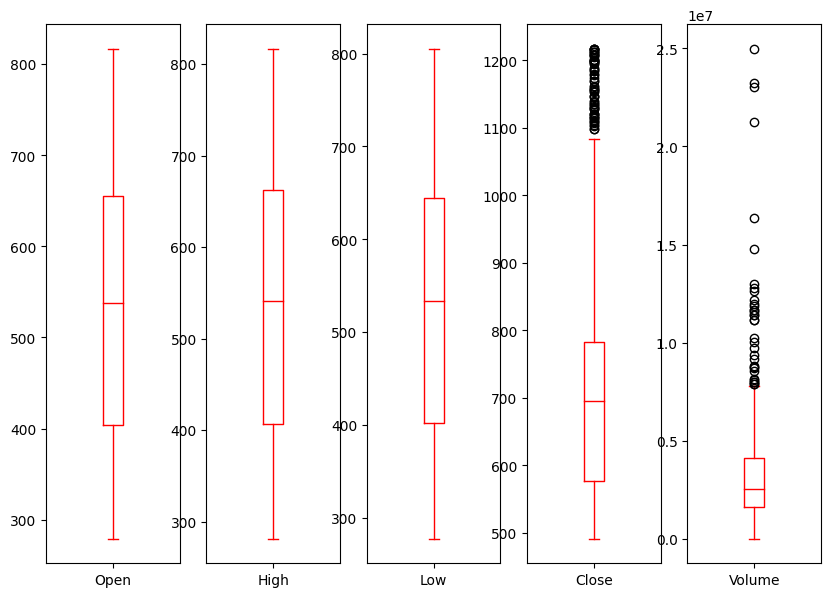

In [12]:
data[['Open','High','Low','Close','Volume']].plot(kind='box', layout=(1,5), subplots=True, sharex=False, sharey=False, figsize=(10,7),color='red')
plt.show()

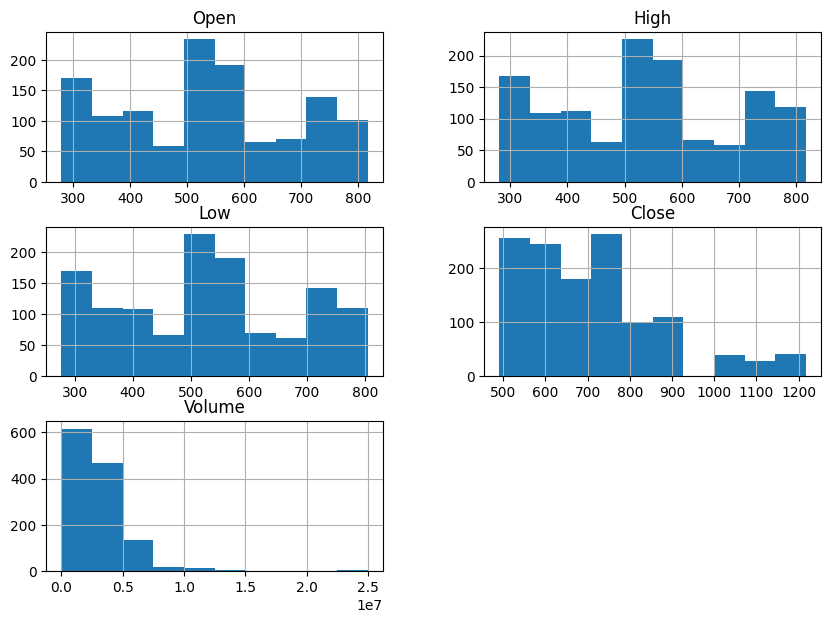

In [14]:
data.hist(figsize=(10,7))
plt.show()

In [34]:
scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))

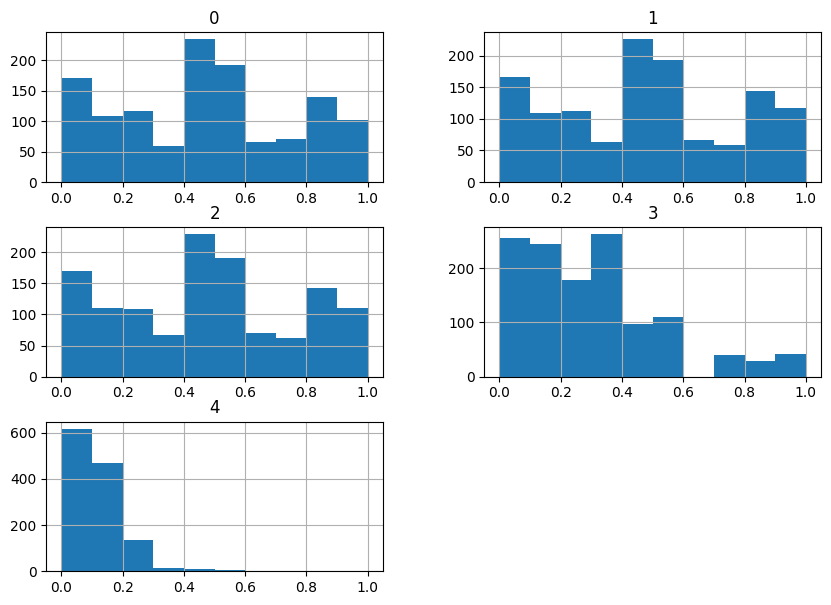

In [35]:
scaled_data.hist(figsize=(10,7))
plt.show()

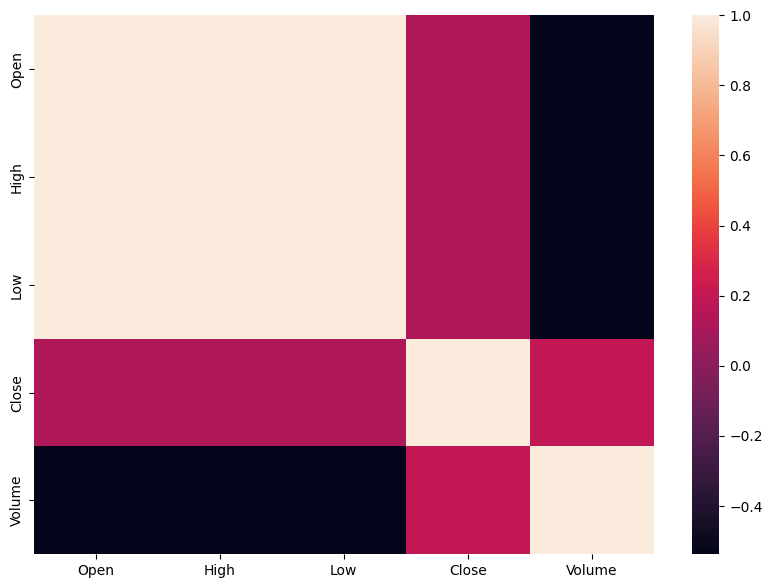

In [36]:
plt.figure(figsize=(10,7))
sns.heatmap(data.drop("Date", axis=1).corr())
plt.show()

In [37]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [38]:
def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x = []
    y = []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window (this indexing is for 2 features vala data only)
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)

In [39]:
n_steps = 60

scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [40]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)

In [41]:
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [42]:
y = y[:, 0]
y.shape

(1198,)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [45]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 612)               1505520   
                                                                 
 dense (Dense)               (None, 50)                30650     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 1540281 (5.88 MB)
Trainable params: 1540281 (5.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [50]:
history = model.fit(x_train, y_train, epochs=250, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/250
30/30 - 1s - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0046 - val_mae: 0.0410 - 1s/epoch - 45ms/step
Epoch 2/250
30/30 - 1s - loss: 9.8473e-04 - mae: 0.0221 - val_loss: 0.0052 - val_mae: 0.0411 - 529ms/epoch - 18ms/step
Epoch 3/250
30/30 - 1s - loss: 8.4283e-04 - mae: 0.0207 - val_loss: 0.0050 - val_mae: 0.0413 - 545ms/epoch - 18ms/step
Epoch 4/250
30/30 - 0s - loss: 7.7966e-04 - mae: 0.0202 - val_loss: 0.0050 - val_mae: 0.0417 - 455ms/epoch - 15ms/step
Epoch 5/250
30/30 - 0s - loss: 7.6793e-04 - mae: 0.0196 - val_loss: 0.0050 - val_mae: 0.0421 - 461ms/epoch - 15ms/step
Epoch 6/250
30/30 - 0s - loss: 7.0780e-04 - mae: 0.0190 - val_loss: 0.0050 - val_mae: 0.0402 - 456ms/epoch - 15ms/step
Epoch 7/250
30/30 - 0s - loss: 7.1152e-04 - mae: 0.0187 - val_loss: 0.0054 - val_mae: 0.0423 - 476ms/epoch - 16ms/step
Epoch 8/250
30/30 - 0s - loss: 6.7412e-04 - mae: 0.0181 - val_loss: 0.0047 - val_mae: 0.0420 - 469ms/epoch - 16ms/step
Epoch 9/250
30/30 - 0s - loss: 6.8164e-04 - mae: 0.0184

<Axes: >

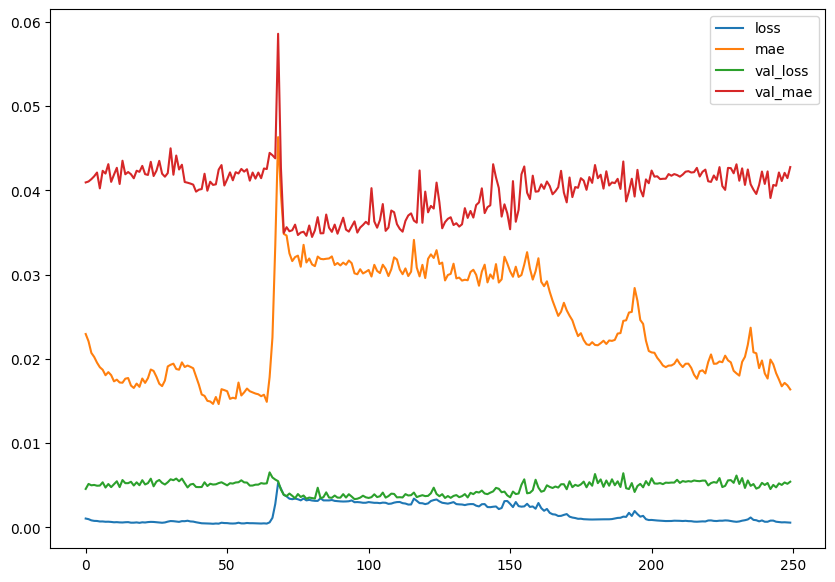

In [51]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [53]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 0s 10ms/step - loss: 0.0054 - mae: 0.0428


[0.005427846219390631, 0.04277690872550011]

In [55]:
predictions = model.predict(x_test)
predictions.shape

8/8 [==============================] - 0s 7ms/step


(240, 1)

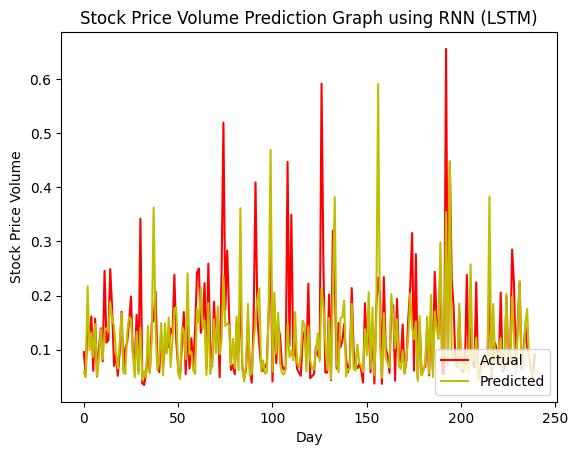

<Figure size 1000x700 with 0 Axes>

In [57]:
plt.plot(y_test, c = 'r')
plt.plot(predictions, c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'], loc = 'lower right')
plt.figure(figsize=(10,7))
plt.show()